In this lab you will do the following steps in order:

1. Load and parse text.
2. Train a LSTM network for single character generation.
3. Generate some text with the trained LSTM network.




Use GPU if available

In [1]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import re

In [2]:
import matplotlib.pyplot as plt

def Print_loss(tst_loss = None, tr_loss = None, figsize = (10,8)):
    
    if tr_loss is None and tst_loss is None: 
        print("ERROR: no values are given")
        return 
    
    if tst_loss is None:
        x = np.arange(1,len(tr_loss)+1)
    else: 
        x = np.arange(1,len(tst_loss)+1)
        
    plt.figure(figsize = figsize)
    
    if tr_loss is not None:
        plt.plot(x,tr_loss, label = "training loss")
        print("Training loss minimum:",np.min(tr_loss))
    
    if tst_loss is not None:    
        plt.plot(x,tst_loss, label = "validation loss")
        print("Validation loss minimum:",np.min(tst_loss))
    
    plt.title("Loss vs epochs")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(alpha=0.3)
    
    return 

1. load dataset

In [4]:
# Download the text file "Alice's Adventures in Wonderland" from Project Gutenberg
#!wget -O wonderland.txt https://www.gutenberg.org/ebooks/11.txt.utf-8

# Load the text data from the downloaded file
filename = "wonderland.txt"
with open(filename, 'r', encoding='utf-8') as f:
  raw_text = f.read()

# Convert all characters to lowercase
raw_text = raw_text.lower()

# Remove non-alphanumeric characters
raw_text = re.sub(r'\n', ' ', raw_text)
raw_text = re.sub(r'[^A-Za-z ]+', '', raw_text)

print(raw_text[500:700])
# Create a set of unique characters in the text
unique_chars = set(raw_text)

# Sort the unique characters
chars = sorted(list(unique_chars))

# Create a dictionary mapping each unique character to a unique integer
char_to_int = dict((c, i) for i, c in enumerate(chars))

# Split the text into training and testing sets
train_start = int(len(raw_text) * 0.1)  # Starting index for training set (10% of text)
train_end = int(len(raw_text) * 0.8)  # Ending index for training set (80% of text)
test_start = train_end  # Starting index for testing set (remaining 20% of text)

raw_text_train = raw_text[train_start:train_end]  # Extract training text
raw_text_test = raw_text[test_start:]  # Extract testing text

# Calculate and print some summary statistics
n_chars_train = len(raw_text_train)
n_chars_test = len(raw_text_test)
n_vocab = len(chars)

print("Total Characters train:", n_chars_train)
print("Total Characters test:", n_chars_test)
print("Total Unique Characters (Vocabulary Size):", n_vocab)
print("Chars: ",chars)

ok  title alices adventures in wonderland  author lewis carroll  release date june   ebook                  most recently updated february    language english  credits arthur dibianca and david widger
Total Characters train: 108293
Total Characters test: 30941
Total Unique Characters (Vocabulary Size): 27
Chars:  [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Prepare the dataset of input to output pairs encoded as integers.

The model takes input sequences of 100 characters and predicts the character 101

In [5]:
# Define the sequence length for character prediction
seq_length = 100

# List to store sequences of characters as integer indices
dataX = []

# List to store target characters (next character) as integer indices
dataY = []

# Loop through the training text with a stride of 1 character
for i in range(0, n_chars_train - seq_length, 1):
  # Extract an input sequence of length 'seq_length' from the training text
  seq_in = raw_text_train[i:i + seq_length]

  # Extract the target character (next character to predict)
  seq_out = raw_text_train[i + seq_length]

  # Convert characters in the input sequence to their integer indices using the mapping dictionary
  dataX.append([char_to_int[char] for char in seq_in])

  # Append the target character's integer index to the output list
  dataY.append(char_to_int[seq_out])

# Count the total number of training patterns (sequences-target character pairs)
n_patterns = len(dataX)
print("Total Patterns train: ", n_patterns)

# Convert the lists of integer indices (dataX and dataY) into PyTorch tensors
X_train = torch.tensor(dataX, dtype=torch.float32)
y_train = torch.tensor(dataY)

# Reshape the input sequences into a 3D tensor with dimensions:
#   - n_patterns: Number of training patterns
#   - seq_length: Length of the input sequence
#   - 1: Number of features (one-hot encoded characters can be represented as floats here)
X_train = X_train.reshape(n_patterns, seq_length, 1)

# Normalize the input sequences by dividing each element by the vocabulary size
# This helps the training process of the model
X_train = X_train / float(n_vocab)

# Prepare testing data (similar to training data preparation)

y_train = torch.tensor(dataY)

#test
dataX = []
dataY = []
for i in range(0, n_chars_test - seq_length, 1):
    seq_in = raw_text_test[i:i + seq_length]
    seq_out = raw_text_test[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns test: ", n_patterns)
# Convert the testing data lists to tensors, reshape, normalize, and create target tensor
X_test = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X_test = X_test / float(n_vocab)
y_test = torch.tensor(dataY)


Total Patterns train:  108193
Total Patterns test:  30841


Train setup and dataloader

## Three layers LSTM

In [7]:
class CharModel(nn.Module):
  """
  Character-Level Language Model using LSTM.

  This class defines a recurrent neural network (RNN) model with a Long Short-Term Memory (LSTM) layer
  for character-level language modeling.

  Attributes:
      lstm: An LSTM layer with specified input size, hidden size, number of layers, and dropout rate.
      linear: A linear layer to map the LSTM output to the vocabulary size (number of characters).
  """

  def __init__(self, n_vocab):
    """
    Initializes the model with an LSTM layer and a linear layer.

    Args:
        None
    """
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=512,  # Hidden size of the LSTM layer
        num_layers=3,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.4  # Dropout rate for regularization
    )

    # Define the linear layer for output
    self.linear = nn.Linear(512, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x: A PyTorch tensor of shape (batch_size, seq_len, features) representing the input sequences.

    Returns:
        A PyTorch tensor of shape (batch_size, vocab_size) containing the model's output logits.
    """

    # Pass the input sequence through the LSTM layer
    # The output (`x`) will be a tuple containing the output tensor and the hidden/cell states (not used here)
    x, _ = self.lstm(x)

    # Print the output shape for debugging purposes (can be commented out)
    # print(x.shape)

    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [8]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs
batch_size = 128  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=1  # Predict character by character for testing
)


In [11]:
from tqdm.auto import tqdm  # Import tqdm for progress bars

tr_loss_list = []
loss_list= []  # save losses for graphical representation

# Initialize variables for early stopping
best_model = None
best_loss = np.inf  # Initialize with positive infinity
patience = 6  # Number of epochs to wait for improvement before stopping

# Training loop
for epoch in tqdm(range(n_epochs)):
    # Set model to training mode
    model.train()

    train_losses = []
    # Iterate through training batches using the data loader
    for X_batch, y_batch in tqdm(loader_train):
        # Clear gradients from the previous iteration
        optimizer.zero_grad()

        # Get predictions for the current batch
        y_pred = model(X_batch.to(device))

        # Calculate loss for the current batch
        loss = loss_fn(y_pred, y_batch.to(device))
        train_losses.append(loss.cpu().detach().numpy())

        # Calculate the average validation loss
       
        # Backpropagate the loss to calculate gradients
        loss.backward()

        # Update model parameters based on the gradients
        optimizer.step()

    # Validation after each epoch
    model.eval()  # Set model to evaluation mode
    avg_training_loss = np.mean(train_losses)
    tr_loss_list.append(avg_training_loss)
    print("training loss: ", avg_training_loss)
    # List to store validation losses
    validation_losses = []

    # Disable gradient calculation for validation (saves memory)
    with torch.no_grad():
        # Iterate through testing batches
        for X_batch, y_batch in loader_test:
            # Get predictions for the validation batch
            y_pred = model(X_batch.to(device))

            # Calculate validation loss for the current batch
            validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()

            # Append the validation loss to the list
            validation_losses.append(validation_loss)

        # Calculate the average validation loss
        avg_validation_loss = np.mean(validation_losses)

        # Track best model and save if validation loss improves
        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_model = model.state_dict()  # Save the model's state dictionary
            torch.save([best_model, char_to_int], "single-charLSTM_3layers.pth")  # Save model and character mapping
            patience = 6  # Reset patience counter for early stopping
            print("**BEST**", end="")  # Print indicator for best model
        else:
            patience -= 1  # Decrement patience counter if validation loss doesn't improve

        # Print epoch information and validation loss
        print("Epoch %d: Cross-entropy: %.4f" % (epoch +1, avg_validation_loss))
        loss_list.append(avg_validation_loss)
        # Implement early stopping
        if patience <= 0:
            print("Stop training!")
            break


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.54391
**BEST**Epoch 1: Cross-entropy: 2.4846


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.0329306
**BEST**Epoch 2: Cross-entropy: 2.3200


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.7898463
**BEST**Epoch 3: Cross-entropy: 2.2567


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.6305332
**BEST**Epoch 4: Cross-entropy: 2.2123


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.5089284
Epoch 5: Cross-entropy: 2.2479


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.4067582
Epoch 6: Cross-entropy: 2.2421


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3214926
Epoch 7: Cross-entropy: 2.2561


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.2417365
Epoch 8: Cross-entropy: 2.3063


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.1642234
Epoch 9: Cross-entropy: 2.3542


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.0927869
Epoch 10: Cross-entropy: 2.4026
Stop training!


Training loss minimum: 1.0927869
Validation loss minimum: 2.2123225


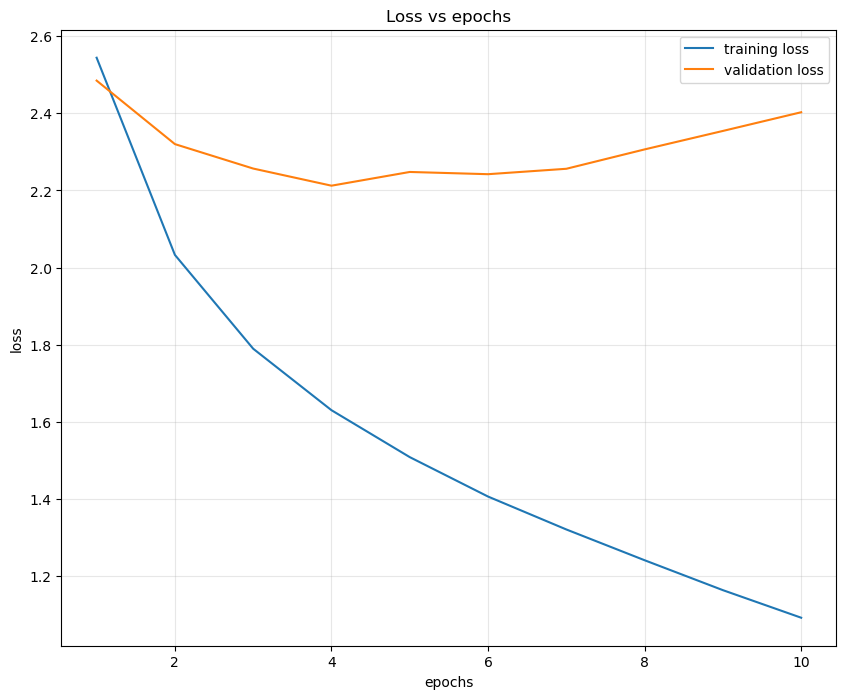

In [12]:
Print_loss(tr_loss=tr_loss_list,tst_loss=loss_list)

## 4 Layers LSTM


In [ ]:
class CharModel(nn.Module):
  """
  Character-Level Language Model using LSTM.

  This class defines a recurrent neural network (RNN) model with a Long Short-Term Memory (LSTM) layer
  for character-level language modeling.

  Attributes:
      lstm: An LSTM layer with specified input size, hidden size, number of layers, and dropout rate.
      linear: A linear layer to map the LSTM output to the vocabulary size (number of characters).
  """

  def __init__(self, n_vocab):
    """
    Initializes the model with an LSTM layer and a linear layer.

    Args:
        None
    """
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=512,  # Hidden size of the LSTM layer
        num_layers=4,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.6  # Dropout rate for regularization
    )

    # Define the linear layer for output
    self.linear = nn.Linear(512, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x: A PyTorch tensor of shape (batch_size, seq_len, features) representing the input sequences.

    Returns:
        A PyTorch tensor of shape (batch_size, vocab_size) containing the model's output logits.
    """

    # Pass the input sequence through the LSTM layer
    # The output (`x`) will be a tuple containing the output tensor and the hidden/cell states (not used here)
    x, _ = self.lstm(x)

    # Print the output shape for debugging purposes (can be commented out)
    # print(x.shape)

    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [ ]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs
batch_size = 128  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=1  # Predict character by character for testing
)


In [ ]:

tr_loss_list = []
loss_list= []  # save losses for graphical representation

# Initialize variables for early stopping
best_model = None
best_loss = np.inf  # Initialize with positive infinity
patience = 6  # Number of epochs to wait for improvement before stopping

# Training loop
for epoch in tqdm(range(n_epochs)):
    # Set model to training mode
    model.train()

    train_losses = []
    # Iterate through training batches using the data loader
    for X_batch, y_batch in tqdm(loader_train):
        # Clear gradients from the previous iteration
        optimizer.zero_grad()

        # Get predictions for the current batch
        y_pred = model(X_batch.to(device))

        # Calculate loss for the current batch
        loss = loss_fn(y_pred, y_batch.to(device))
        train_losses.append(loss.cpu().detach().numpy())

        # Calculate the average validation loss
       
        # Backpropagate the loss to calculate gradients
        loss.backward()

        # Update model parameters based on the gradients
        optimizer.step()

    # Validation after each epoch
    model.eval()  # Set model to evaluation mode
    avg_training_loss = np.mean(train_losses)
    tr_loss_list.append(avg_training_loss)
    print("training loss: ", avg_training_loss)
    # List to store validation losses
    validation_losses = []

    # Disable gradient calculation for validation (saves memory)
    with torch.no_grad():
        # Iterate through testing batches
        for X_batch, y_batch in loader_test:
            # Get predictions for the validation batch
            y_pred = model(X_batch.to(device))

            # Calculate validation loss for the current batch
            validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()

            # Append the validation loss to the list
            validation_losses.append(validation_loss)

        # Calculate the average validation loss
        avg_validation_loss = np.mean(validation_losses)

        # Track best model and save if validation loss improves
        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_model = model.state_dict()  # Save the model's state dictionary
            torch.save([best_model, char_to_int], "single-charLSTM_4layers.pth")  # Save model and character mapping
            patience = 6  # Reset patience counter for early stopping
            print("**BEST**", end="")  # Print indicator for best model
        else:
            patience -= 1  # Decrement patience counter if validation loss doesn't improve

        # Print epoch information and validation loss
        print("Epoch %d: Cross-entropy: %.4f" % (epoch +1, avg_validation_loss))
        loss_list.append(avg_validation_loss)
        # Implement early stopping
        if patience <= 0:
            print("Stop training!")
            break


In [ ]:
Print_loss(tr_loss=tr_loss_list,tst_loss=loss_list)

# Big 5 layers

In [ ]:
class CharModel(nn.Module):
  """
  Character-Level Language Model using LSTM.

  This class defines a recurrent neural network (RNN) model with a Long Short-Term Memory (LSTM) layer
  for character-level language modeling.

  Attributes:
      lstm: An LSTM layer with specified input size, hidden size, number of layers, and dropout rate.
      linear: A linear layer to map the LSTM output to the vocabulary size (number of characters).
  """

  def __init__(self, n_vocab):
    """
    Initializes the model with an LSTM layer and a linear layer.

    Args:
        None
    """
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=1024,  # Hidden size of the LSTM layer
        num_layers=5,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.5  # Dropout rate for regularization
    )

    # Define the linear layer for output
    self.linear = nn.Linear(1024, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x: A PyTorch tensor of shape (batch_size, seq_len, features) representing the input sequences.

    Returns:
        A PyTorch tensor of shape (batch_size, vocab_size) containing the model's output logits.
    """

    # Pass the input sequence through the LSTM layer
    # The output (`x`) will be a tuple containing the output tensor and the hidden/cell states (not used here)
    x, _ = self.lstm(x)

    # Print the output shape for debugging purposes (can be commented out)
    # print(x.shape)

    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [ ]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs
batch_size = 128  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=1  # Predict character by character for testing
)


Training loss minimum: 1.5521
Validation loss minimum: 2.3254


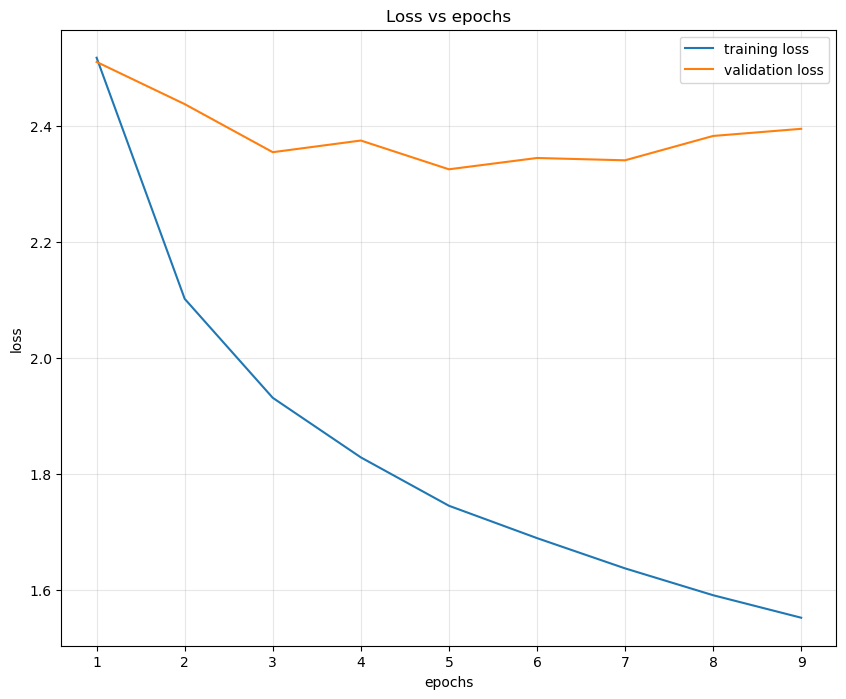

In [4]:
Print_loss(tr_loss=tr_loss_list,tst_loss=loss_list)

In [3]:
tr_loss_list = [2.5178,2.1020,1.9313,1.8286,1.7452,1.6894,1.6372,1.5909,1.5521]
loss_list = [2.5105,2.4378,2.3549,2.3750,2.3254,2.3449,2.3409,2.3829,2.3952]